In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent   # because notebook is in /Notebooks
FIGURES_DIR = PROJECT_ROOT / "figures"

In [2]:
# Load cleaned RentTheRunway data
df = pd.read_csv("../Data/Processed/renttherunway_clean.csv")

# Select numeric body-measurement features
features = [
    "height_inches",
    "weight_lbs",
    "bmi",
    "age",
    "bust_band",
    "cup_size_num"
]

X = df[features].dropna()

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

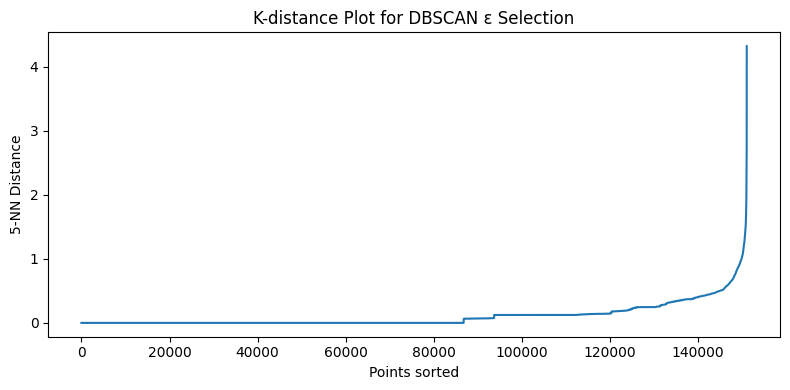

In [20]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(distances)
plt.ylabel("5-NN Distance")
plt.xlabel("Points sorted")
plt.title("K-distance Plot for DBSCAN ε Selection")
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "dbscan_pca_projection.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [5]:
dbscan = DBSCAN(
    eps=0.9,        # tune from k-distance plot
    min_samples=5,
    metric="euclidean"
)

db_labels = dbscan.fit_predict(X_scaled)

In [6]:
X_db = X.copy()
X_db["dbscan_cluster"] = db_labels

In [7]:
X_db["dbscan_cluster"].value_counts()

dbscan_cluster
 0     72346
 1     37437
 2     31870
 4      6770
-1      1236
       ...  
 55        5
 57        5
 62        5
 63        5
 75        5
Name: count, Length: 80, dtype: int64

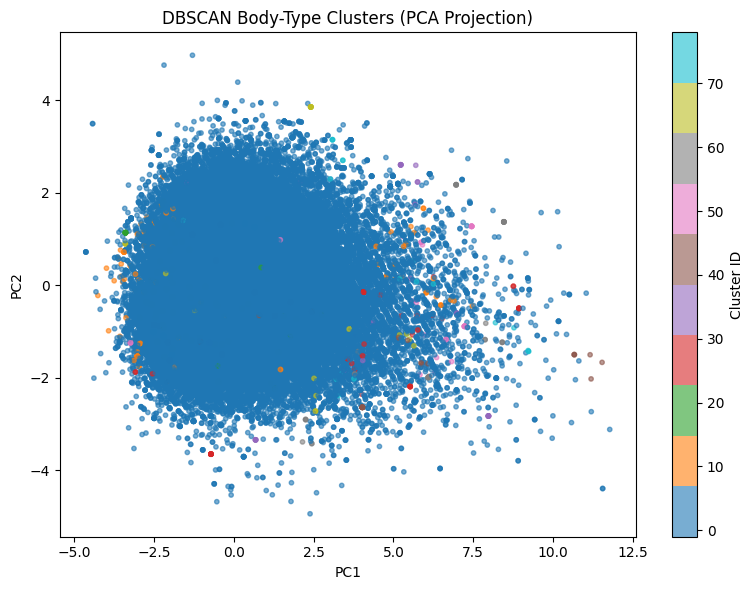

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=db_labels,
    cmap="tab10",
    s=10,
    alpha=0.6
)
plt.title("DBSCAN Body-Type Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster ID")
plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "tsne_dbscan_clusters.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [9]:
sample_size = 5000
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)

X_sample = X_scaled[sample_idx]
labels_sample = db_labels[sample_idx]

In [11]:
pca_tsne = PCA(n_components=6, random_state=42)
X_pca_tsne = pca_tsne.fit_transform(X_sample)

In [13]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42
)

X_tsne = tsne.fit_transform(X_pca_tsne)

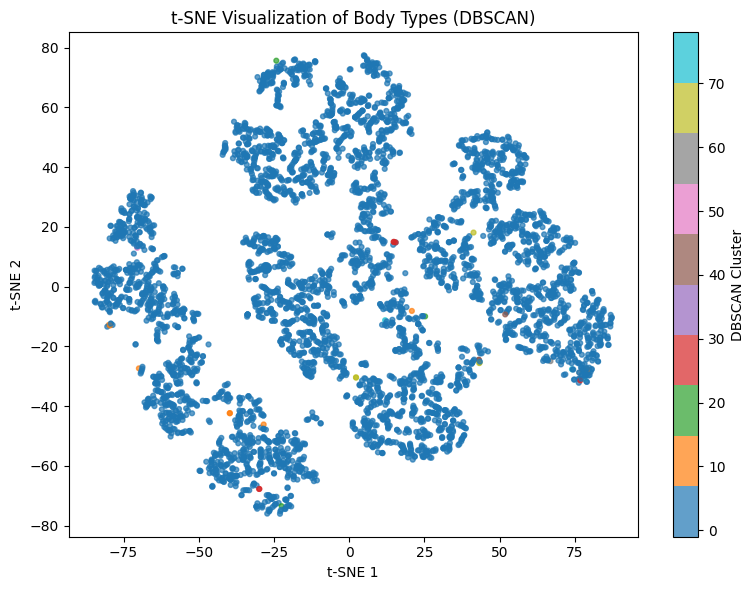

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=labels_sample,
    cmap="tab10",
    s=12,
    alpha=0.7
)
plt.title("t-SNE Visualization of Body Types (DBSCAN)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="DBSCAN Cluster")

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "tsne_dbscan_clusters.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

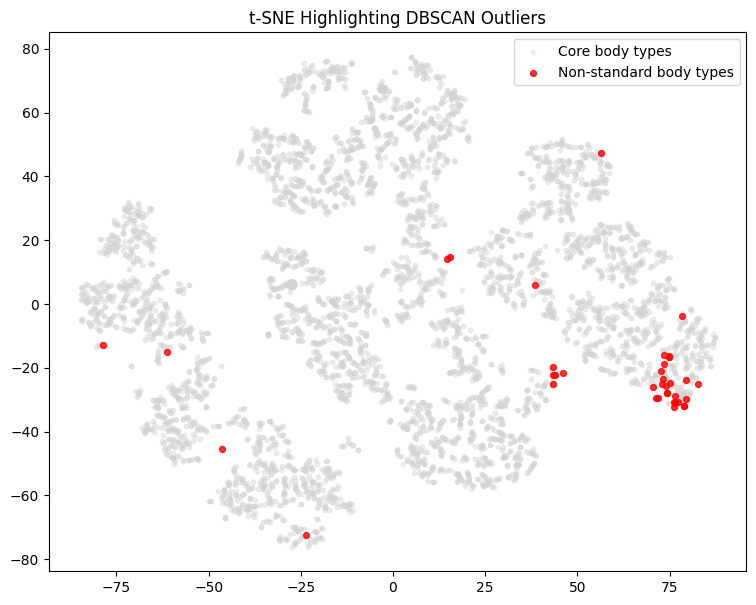

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(
    X_tsne[labels_sample != -1,0],
    X_tsne[labels_sample != -1,1],
    c="lightgray",
    s=10,
    alpha=0.4,
    label="Core body types"
)

plt.scatter(
    X_tsne[labels_sample == -1,0],
    X_tsne[labels_sample == -1,1],
    c="red",
    s=18,
    alpha=0.9,
    label="Non-standard body types"
)

plt.legend()
plt.title("t-SNE Highlighting DBSCAN Outliers")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "tsne_dbscan_outliers.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [17]:
df.to_csv(
    "../Data/Processed/renttherunway_with_dbscan.csv",
    index=False
)

# DBSCAN Body-Type Clustering and Visualization

To explore latent structure in customer body measurements without imposing rigid assumptions on cluster shape or count, we applied DBSCAN to standardized continuous body-measurement features (height, weight, BMI, age, bust band, and cup size). DBSCAN is particularly well suited to this problem because human body measurements vary continuously and do not naturally partition into well-separated clusters. Rather than forcing segmentation, DBSCAN identifies dense regions of common body profiles and explicitly labels atypical observations as noise.

## PCA Projection of DBSCAN Clusters

The first figure presents a two-dimensional PCA projection of the DBSCAN clustering results. The visualization reveals one dominant dense region containing the majority of customers, along with several small peripheral clusters and scattered observations. This pattern reflects the underlying reality of body measurements: most customers fall within a broad continuum of “typical” body types, while a smaller subset occupies less common regions of the measurement space.

Importantly, the lack of sharply separated clusters in PCA space should not be interpreted as a failure of DBSCAN. PCA preserves global variance but compresses six dimensions into two, which inevitably causes overlap. Instead, this projection highlights why fixed sizing systems struggle—body dimensions do not naturally form discrete, linearly separable groups. The presence of peripheral clusters and dispersed points suggests meaningful heterogeneity that is not captured by standard size labels alone.

## t-SNE Visualization of DBSCAN Clusters

To better examine local neighborhood structure, we next applied t-SNE to a PCA-denoised subset of the data. Unlike PCA, t-SNE emphasizes local similarity, making it well suited for visualizing fine-grained structure in high-dimensional measurement spaces.

The t-SNE visualization reveals multiple compact, well-defined regions corresponding to local body-type neighborhoods. While most points still belong to a dominant cluster, the separation between neighborhoods is far more apparent than in the PCA projection. This demonstrates that although body measurements vary continuously, there exist localized pockets of similarity that DBSCAN can identify in the original feature space. These local neighborhoods are especially relevant for personalized size recommendation, as customers within the same neighborhood are more likely to experience similar fit outcomes for the same garment.

## Highlighting DBSCAN Outliers

The final figure isolates DBSCAN-identified outliers (noise points) and overlays them on the t-SNE embedding. These observations represent non-standard body types that do not belong to any dense region of the measurement space. Visually, these outliers tend to lie at the edges of local neighborhoods or in sparse regions between clusters.

From a modeling perspective, these outliers are particularly important. Customers with atypical body profiles are more likely to experience “Small” or “Large” fit outcomes and are therefore at higher risk of misfit and product return. Rather than discarding these observations, DBSCAN allows us to explicitly flag them and incorporate this information into downstream supervised models as an informative feature.

## Implications for Fit Prediction

Together, these visualizations support several key insights that motivate later modeling choices:

Body measurements form a continuous, overlapping space, not discrete clusters, explaining why simple rule-based sizing systems perform poorly.

Local structure exists and can be revealed through nonlinear embeddings such as t-SNE, justifying neighborhood-based reasoning in size recommendation.

Atypical body types are identifiable via density-based methods and represent a critical subgroup for improving misfit prediction.

For these reasons, DBSCAN cluster membership—and particularly the identification of outliers—is retained as an engineered feature in Phase 2 supervised fit-prediction models and in the Phase 3 size recommender system.